In [1]:
import numpy as np

x=np.load("variables/x.npy")
y=np.load("variables/y.npy")
x_train=np.load("variables/x_train.npy")
x_test=np.load("variables/x_test.npy")
y_test=np.load("variables/y_test.npy")
y_train=np.load("variables/y_train.npy")

## STOCHASTIC GRADIENT DECENT CLASSIFIER:

In [2]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=200, random_state=42)
sgd_clf.fit(x_train, y_train) 

SGDClassifier(max_iter=200, random_state=42)

In [3]:
sgd_clf.score(x_train,y_train)

0.8378684807256236

### VALIDATION CROISÉE :

In [4]:
from sklearn.model_selection import cross_val_score

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())
    
sgd_clf_scores = cross_val_score(sgd_clf, x, 
                                      y, cv=10, scoring="f1")

display_scores(sgd_clf_scores)

Scores: [0.34862385 0.3        0.49253731 0.4962406  0.34482759 0.22988506
 0.22680412 0.49612403 0.46031746 0.19753086]
Mean: 0.3592890891059849
Standard deviation: 0.11390470154628711


### GridSearchCV
Afin de trouver les meilleurs paramètres, nous allons utiliser la méthode d'optimisation GridSearchCV.

In [5]:
%%capture --no-display
from sklearn.model_selection import GridSearchCV


sgd_clf_param_grid = [
    {'alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3],
    'loss': ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron'], 
     'penalty': ['l1', 'l2', 'elasticnet']}
  ]

grid_search = GridSearchCV(sgd_clf, sgd_clf_param_grid, cv=10,
                           scoring='f1', return_train_score=True)
grid_search.fit(x, y)

GridSearchCV(cv=10, estimator=SGDClassifier(max_iter=200, random_state=42),
             param_grid=[{'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0,
                                    1000.0],
                          'loss': ['hinge', 'log', 'modified_huber',
                                   'squared_hinge', 'perceptron'],
                          'penalty': ['l1', 'l2', 'elasticnet']}],
             return_train_score=True, scoring='f1')

In [6]:
grid_search.best_params_

{'alpha': 0.0001, 'loss': 'modified_huber', 'penalty': 'l1'}

In [7]:
best_sgd = grid_search.best_estimator_

In [8]:
%%capture --no-display
from sklearn.model_selection import cross_val_score

best_sgd_score = cross_val_score(best_sgd, x, 
                                          y, cv=10, scoring="f1")

In [9]:
display_scores(best_sgd_score)

Scores: [0.36842105 0.27272727 0.46017699 0.45333333 0.33333333 0.4379562
 0.38926174 0.45945946 0.39694656 0.46391753]
Mean: 0.4035533482640118
Standard deviation: 0.060963643096961354


### Matrice de Confusion

Nous allons maintenant utiliser afin d'étudier les performances de notre système de classification supervisé. Calculons maintenant cette matrice avec notre modèle amélioré.

In [10]:
%%capture --no-display

from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(best_sgd, x_train, y_train, cv=10)

In [11]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train, y_train_pred)

array([[2469,  487],
       [ 339,  233]], dtype=int64)

In [12]:
y_train_perfect_predictions = y_train
confusion_matrix(y_train, y_train_perfect_predictions)

array([[2956,    0],
       [   0,  572]], dtype=int64)

### Recall et precision en fonction du seuil
Affichons les valeurs du recall et de la précision en fonction du seuil ainsi que la valeur de la précision en fonction du recall

In [13]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train, y_train_pred)

0.3236111111111111

In [14]:
recall_score(y_train, y_train_pred)

0.40734265734265734

In [15]:

y_scores = cross_val_predict(best_sgd, x_train, y_train, cv=10,
                             method="decision_function")

In [16]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)

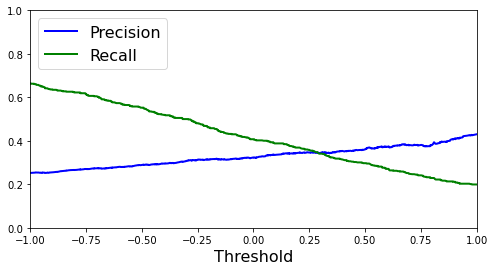

In [17]:
from matplotlib import pyplot as plt

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b-", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([-1, 1])
#save_fig("precision_recall_vs_threshold_plot")
plt.show()

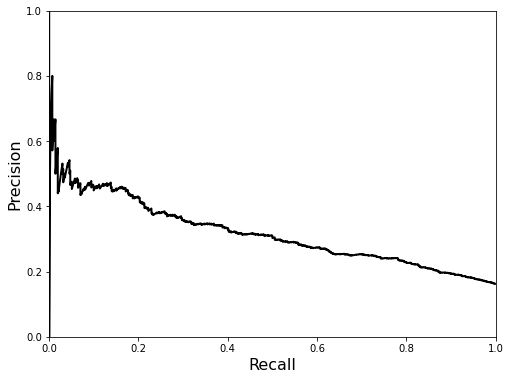

In [18]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "k-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
#save_fig("precision_vs_recall_plot")
plt.show()

In [19]:
y_train_pred_90 = (y_scores > 0.3)
thresholds
precision_score(y_train, y_train_pred_90), recall_score(y_train, y_train_pred_90)

(0.34452296819787986, 0.3409090909090909)

 ### Courbe ROC
 Affichons la courbe roc afin de confronter notre taux de vrai positif par rapport au taux de faux positif. plus la courbe se rapproche du coin supérieur gauche, plus notre taux de vrai positif est idéal, et on évite un maximum de faux positif. On utilise l'air sous la courbe ROC afin de comparer nos modèles, qui doit être le plus proche de 1.

In [20]:
from sklearn.metrics import roc_curve

fpr_sgd, tpr_sgd, thresholds = roc_curve(y_train, y_scores)

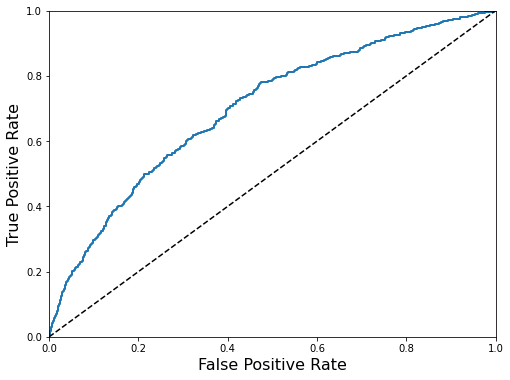

In [21]:
def plot_roc_curve(fpr_sgd, tpr_sgd, label=None):
    plt.plot(fpr_sgd, tpr_sgd, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr_sgd, tpr_sgd)
#save_fig("roc_curve_plot")
plt.show()

In [22]:
from sklearn.metrics import roc_auc_score 

roc_auc_score(y_train, y_scores) 

0.7003605325662159

In [24]:
np.save('variables/fpr_sgd.npy', fpr_sgd)
np.save('variables/tpr_sgd.npy', tpr_sgd)